<a href="https://colab.research.google.com/github/HanlunAI/ATasteOfDeepLearning/blob/main/ST5_001_Classics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Taste of Deep Learning through Python 

# Session 1: The Classics (Regression and Classification)
You have to know the past to understand the present.

-- Carl Sagan


In deep learning, there are supervised learning tasks, unsupervised learning tasks, and even some interesting [generative tasks](https://thisxdoesnotexist.com/). 

**Supervised learning** could be used to predict the value of a variable based on the value of (most likely multiple) other variable(s). Sometime we further divide supervised learning tasks as a **regression** problem when output is a continuous variable; and as a **classification** problem when output is a categorical variable. We shall come across **many** ideas from the literature in this notebook.

### 1.1 Linear Regression for small data

A simpler well-understood class of regression is called *linear regression* that predict with a linear relation. For a small example, we devote **Section 1.1** to study a small dataset appeared in an article published in [School Mathematics Newsletter (Issue 23, p.65-74)](https://www.edb.gov.hk/attachment/en/curriculum-development/kla/ma/res/smn_23.pdf).

Linear regression is just finding the best-fit line if there are just 1 independent variable and 1 dependent variable. How about cases of higher dimension? In a thought (or maybe foreign) city, a small dataset consisting of 4 attributes and the price of 6 real estate property is given. Linear regression for small dataset is given in a formula and Python is recommended to perform computation! So here we try:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Latex
#x_0 is here for homogeneity
d = {"x_0": [1,1,1,1,1,1],
     "面積 x_1": [2104,1416,1534,852,564,745],
     "房數 x_2": [5,3,3,2,2,3],
     "層數 x_3": [1,2,2,1,1,2],
     "樓齡 x_4": [45,40,30,36,15,20],
     "樓價 y": [460,232,315,178,250,220]}
#Pandas is a popular package for DataFrame
df = pd.DataFrame(data=d)
display(df.style.hide_index())
#print(df.shape)
X = df.drop(columns = "樓價 y").to_numpy()
Y = df["樓價 y"].to_numpy()

#This is the magic line for linear regression
theta = np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.matmul(np.transpose(X),Y))
 
#or in simplified numpy expression
#theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
#these concerns some linear operation, and work pretty well computationally for small cases
print("\n")

toPrint = np.around(theta, decimals=4)
display(Latex(f"y ≈ {toPrint[0]} + ({toPrint[1]})x_1 + ({toPrint[2]})x_2 + ({toPrint[3]})x_3 + ({toPrint[4]})x_4."))

x_0,面積 x_1,房數 x_2,層數 x_3,樓齡 x_4,樓價 y
1,2104,5,1,45,460
1,1416,3,2,40,232
1,1534,3,2,30,315
1,852,2,1,36,178
1,564,2,1,15,250
1,745,3,2,20,220


<IPython.core.display.Latex object>

But how good is linear regression performing on this small dataset?

Real estates in the thought city priced at [460 232 315 178 250 220];
and linear regression gives [460.  231.2 315.5 178.5 249.5 220.3].


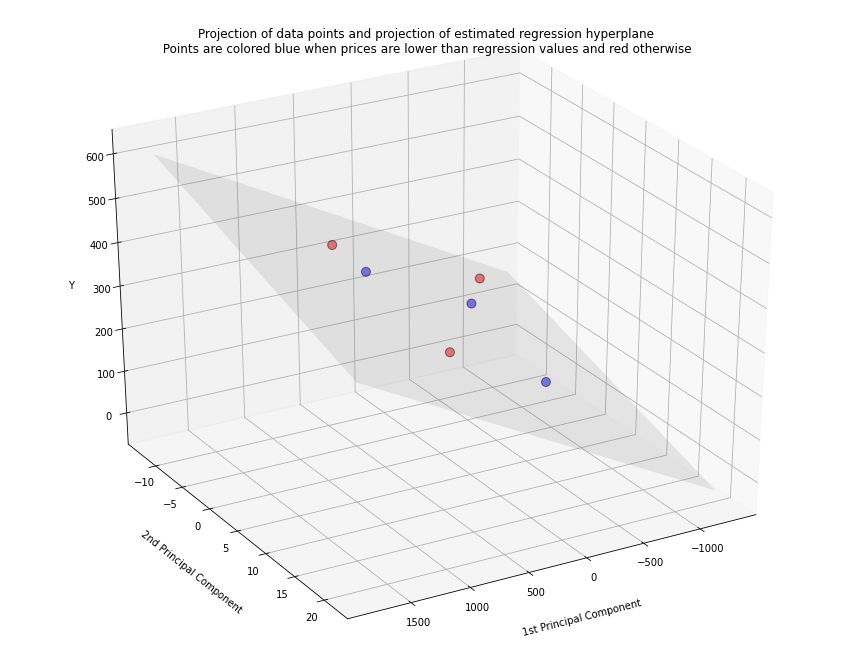

In [3]:
#@title After running previous cells, just run this to see \~.\~
import matplotlib
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
pca = PCA(n_components = 2)
pca.fit(X)
X_trs = pca.transform(X)
xx0, xx1 = np.meshgrid(np.array([np.min(X_trs[:,0]),np.max(X_trs[:,0])])*2, np.array([np.min(X_trs[:,1]),np.max(X_trs[:,1])])*2)
lr = LinearRegression()
Yhat = np.dot(X,theta)
model = lr.fit(X_trs, Yhat)
YY = model.intercept_ + xx0 * model.coef_[0] + xx1 * model.coef_[1]
fig1 = plt.figure(figsize = (15,12))
ax = fig1.gca(projection='3d')
ax.plot_surface(xx0, xx1, YY, color = 'grey', alpha = 0.1)
potential = Y < Yhat
ax.scatter(X_trs[potential][:,0], X_trs[potential][:,1], Y[potential], s = 80, marker = 'o', edgecolors= 'k', alpha = 0.5, c = "blue")
ax.scatter(X_trs[~potential][:,0], X_trs[~potential][:,1], Y[~potential], s = 80, marker = 'o', edgecolors= 'k', alpha = 0.5, c = "red")
ax.set_xlabel('1st Principal Component', labelpad = 20)
ax.set_ylabel('2nd Principal Component',  labelpad = 20)
ax.set_zlabel('Y', labelpad = 10)
ax.set_title('Projection of data points and projection of estimated regression hyperplane\n Points are colored blue when prices are lower than regression values and red otherwise')
#ax.view_init(10, 95)
ax.view_init(30, 60)
print('Real estates in the thought city priced at {};'.format(Y))
print('and linear regression gives {}.'.format(np.around(Yhat, decimals=1)))

### 1.2 Picking Up Some Important Notions As We Move On

**Brainstorming**

The exercise in Section 1.1 actually invited more questions:

1. In a thought city, there could be numerous household properties, say as many as **1,000,000** properties. Is there an algorithm that could *scale up* efficiently?

2. Our eyes are comfortable with at most 3D-plot, why don't we restrict to just 2 principal features for the time being, say **KPI1** and **KPI2** on respectively attribute for *location* and *facilities*?

3. In the magic line, **matrix** operations do most of the job, could we at least have a *motivating example* to understand how matrices could operate?

To deal with these questions, we will tell a few more stories in this notebook. These stories may seem to be unrelated in the beginning, but added up to give answer to these curiosity.

Specifically, we will introduce matrix operation in **Section 1.2.1** with another simple tale on household properties. 
Then we will introduce a numerical method that relies on repeated random sampling in **Section 1.2.2** for later mini-batch data processing; and learn the story of updates of belief in **Section 1.2.3**. All these would later help us to answer the **1,000,000** household properties problem in **Section 1.3**. 

### 1.2.1 Markov Chain and Matrix Operations

Let Larry be a rich guy. There are $3$ residential properties he usually stay, namely $S_1$, $S_2$ and $S_3$ as shown in the following picture:

![picture](https://drive.google.com/uc?id=1juhNSywr8zDZN75PlUj4tqzxvJwp9zRz)

Larry would stay in one property say $S_i$ for a full month, and randomly transit to (or stay at) property $S_j$ with a transition probability $0\leq p_{i,j} \leq 1$, for $1\leq i,j \leq 3$ for the next month. 

A systematic bookkeeping  of the above fancy picture is to record all **transition probabilities** in **rows** and **columns** like:

$\displaystyle{ P = \left(\begin{array}{ccc}
p_{1,1}=\frac{3}{10} & p_{1,2}=\frac{3}{5} & p_{1,3}=\frac{1}{10}\\
p_{2,1}=\frac{3}{5} & p_{2,2}=\frac{1}{5} & p_{2,3}=\frac{1}{5}\\
p_{3,1}=\frac{3}{10} & p_{3,2}=\frac{1}{5} & p_{3,3}=\frac{1}{2}
\end{array} \right)}$


so that the $i$-th row recorded transition probabilities from $S_i$ and the $j$-th column recorded transition probabilities to $S_j$.



Remember that we are doing some Mathematics. Let's try to calculate simple things first:
1.   In the *previous* month, he stayed in property $S_1$. What is his probability of staying in $S_1$, $S_2$ and $S_3$ in this month?
2.   In the *previous* month, his probability of staying in $S_1$, $S_2$ and $S_3$  are respectively $x_1$, $x_2$ and $x_3$? Try at least the special case when $x_1 = 0.5$, $x_2 = 0.3$ and $x_3 = 0.2$.
3.   Could we determine his probability of staying in $S_1$, $S_2$ and $S_3$ after $5$ months? How about in the long run?

**1.2.1.1** Answer 

**Simple answer.** In this case, the probability of staying in $S_1, S_2$ and $S_3$ is just respectively the 3 entries of the **1st row** of the bookkeeping $P$~

**1.2.1.2** Answer 

**Still not too hard.** We just need some patience and [*the law of total probability*](https://mathworld.wolfram.com/TotalProbabilityTheorem.html)~

The probability he stay in $S_1$ is just $x_1p_{1,1} + x_2p_{2,1} + x_3p_{3,1}$. (i.e. in other words, this is simply the *dot product* of $[x_1, x_2, x_3]$ and the vector corresponding to the **1st column** of the above bookkeeping $P$.)

The probability he stay in $S_2$ is just $x_1p_{1,2} + x_2p_{2,2} + x_3p_{3,2}$. (i.e. in other words, this is simply the *dot product* of $[x_1, x_2, x_3]$ and the vector corresponding to the **2nd column** of the above bookkeeping $P$.)

The probability he stay in $S_3$ is just $x_1p_{1,3} + x_2p_{2,3} + x_3p_{3,3}$. (i.e. in other words, this is simply the *dot product* of $[x_1, x_2, x_3]$ and the vector corresponding to the **3rd column** of the above bookkeeping $P$.)

Now, we shall let computer do the computation:

In [4]:
import numpy as np
x = np.array([[0.5,0.3,0.2]])
P = np.array([[0.3,0.6,0.1],[0.6,0.2,0.2],[0.3,0.2,0.5]])
#Larry had friends like him, with other transition matrix to play with
#Q = np.array([[0.3,0.6,0.1],[0.2,0.6,0.2],[0.3,0.2,0.5]])
#R = np.array([[0.1,0.6,0.3],[0.6,0.2,0.2],[0.3,0.2,0.5]])
x = np.matmul(x,P)
print("In the next months, Larry's probabilities of staying in S1, S2 and S3 are respectively", x)

In the next months, Larry's probabilities of staying in S1, S2 and S3 are respectively [[0.39 0.4  0.21]]


Congratulations! This example already captured some essence of **matrix multiplication** operation, with $P$ being a special matrix called a transition matrix. 

*More illustration shall be elaborated during workshop. (The general setting of multiplication between a $m$ by $n$ matrix and a $n$ by $l$ matrix may arise from considering $m$ queries in a stack for transition in bipartite graph from $n$ places to $l$ places; though the sum-to-one property is not necessary for general matrices)*

**1.2.1.3** Answer

**Similarly**, we may iterative perform the matrix multiplication 5 times in a row to determine the probabilities after 5 months:

In [5]:
import numpy as np
x = np.array([[0.5,0.3,0.2]])
P = np.array([[0.3,0.6,0.1],[0.6,0.2,0.2],[0.3,0.2,0.5]])
for i in range(5):
  x = np.matmul(x,P)
print("After 5 months, Larry's probabilities of staying in S1, S2 and S3 are respectively", x)

After 5 months, Larry's probabilities of staying in S1, S2 and S3 are respectively [[0.408816 0.36416  0.227024]]


Note that matrix multiplication is assoicative, so one may also perform computation like this as well:

In [6]:
import numpy as np
from numpy.linalg import matrix_power
x = np.array([[0.5,0.3,0.2]])
P = np.array([[0.3,0.6,0.1],[0.6,0.2,0.2],[0.3,0.2,0.5]])
x = np.matmul(x,matrix_power(P, 5))
print("After 5 months, Larry's probabilities of staying in S1, S2 and S3 are respectively", x)

After 5 months, Larry's probabilities of staying in S1, S2 and S3 are respectively [[0.408816 0.36416  0.227024]]


The latter way is preferable for both computational efficiency and robustness to resist accumulation of errors. (The former suffers from both issues.) We may play with the matrix power for a very high power here:

In [7]:
import numpy as np
from numpy.linalg import matrix_power
x = np.array([[0.5,0.3,0.2]])
P = np.array([[0.3,0.6,0.1],[0.6,0.2,0.2],[0.3,0.2,0.5]])
n = 200
highPowerP = matrix_power(P, n)
print("The matrix for a {}-month-transition is \n{};\n".format(n,highPowerP))
x = np.matmul(x, highPowerP)
print("After {} months, Larry's probabilities of staying in S1, S2 and S3 are respectively {}.".format(n,x))

The matrix for a 200-month-transition is 
[[0.40909091 0.36363636 0.22727273]
 [0.40909091 0.36363636 0.22727273]
 [0.40909091 0.36363636 0.22727273]];

After 200 months, Larry's probabilities of staying in S1, S2 and S3 are respectively [[0.40909091 0.36363636 0.22727273]].


One may try with several pairs of appropriate x and P in the above code cell. One shall see that in the long run, the probability status depends on only P but not x.

**Some remarks**
*   sum-to-one
*   random walk
*   dominant eigenvector
*   very efficient for persistent linear relation in discrete time
*   **Simple** idea? **Serious** [big money in the real world](https://www.math.arizona.edu/~glickenstein/math443f08/bryanleise.pdf): [PageRank](https://en.wikipedia.org/wiki/PageRank)



### 1.2.2 Monte Carlo Simulation
Two ways to do prediction: one is by theory; another is to simulate (a.k.a. experiment) it at all!

Inclusion of randomness in simulation allows one to perform repeated random sampling. Summarizing these observations may in return give numerical estimation to deterministic (previously unknown) parameter. An entire class of method follow this simple idea is called Monte Carlo Simulation.

In mathematics, statistics, physics and other areas, when parameter values are hard to determine otherwise, people often resort to these Monte Carlo Simulation/ Monte Carlo Experiments.


![picture](https://drive.google.com/uc?id=1637NnEjLKMED6C86qtVJ4TgoCtPigrDn)

**1.2.2.1 Resources from the web**

A classical example of Monte Carlo Experiment is the [Buffon's needle experiment](https://mathworld.wolfram.com/BuffonsNeedleProblem.html). As in the link to Wolfram Mathworld, by result of **integration** (something we will learn in the DSE subject M1/M2):

The theoretic proportion of needles cutting a line is related to $\pi$ by $\displaystyle{p = \frac{2}{\pi}\times\frac{l}{t}}$, where $l$ is the line of needles and $t$ is the width between lines.

A simulation of needles cutting lines (or equivalently, in a special coin games for vertical coins hitting gaps) would then produce an estimation of $\pi$.

Kyle Siegrist from University of Alabama in Huntsville constructed a nice website devoted to mathematical statistics: http://www.randomservices.org/random/. Please check out his [web-application](https://www.randomservices.org/random/apps/BuffonNeedle.html) on the classical Buffon's needle problem. Over there, you may specify your choice of $L = \frac{l}{t}$ for your own simulation to estimate $\pi$. You may also select "*Stop: 10000*"/"*Stop: never*" and click the "*fast play*" button to observe the experimental converge as simulation goes on.

**1.2.2.2 Some Python codes**

Of course, we could write in our own python codes:

In [8]:
import numpy as np
l,t,N,counter = 1,2,100000,0
for k in range(N):
  y = t*np.random.uniform(0,1)                # randomly draw y-coordinate
  theta = np.random.uniform(0,2*np.pi)        # randomly draw theta (inclination angle)
  y1 = y + (l/2)*np.sin(theta)                #calculate the y-coordinate of two ends of needle
  y2 = y - (l/2)*np.sin(theta)
  if y1 > t or y1 < 0 or y2>t or y2<0:        # check if y is outside the bound
    counter+=1
p = counter/N                                 # probability
print("A Monte Carlo Estimation of Pi is {}.".format((2/p)*(l/t)))

A Monte Carlo Estimation of Pi is 3.161755406601745.


In fact, a more modern way of estimating $\pi$ with Monte Carlo (on a computer) is in the following:

In [9]:
import numpy as np
N = 100000
x = np.random.uniform(0,1,N)
y = np.random.uniform(0,1,N)
r = np.sqrt(x**2+y**2)
count = (r < 1).sum()
print("Another Monte Carlo Estimation of Pi is {}.".format(4*count/N))

Another Monte Carlo Estimation of Pi is 3.13784.


**1.2.2.3** Checkpoint
*   Do you know the geometric meaning of the above codes?
*   Computationally, for a numerical approximation to $\pi$, Monte Carlo is not as effective as [*continued fraction*](https://mathworld.wolfram.com/PiContinuedFraction.html). 
*   But Monte Carlo techniques come in handy in many practical real-world cases, especially when we have only limited knowledge on cost function and still want to solve some optimization problems.





### 1.2.3 Almost There

**The Bayesian Approach**

**1.2.3.1 Testing Positive? What does that mean?**

Let $E$ be the event that someone is tested positive for a disease; $H$ be the event that someone actually have that disease. Then
$$P(H|E) = \frac{P(H \cap E)}{P(E)}= \frac{P(E | H)P(H)}{P(E | H)P(H)+P(E | \overline{H})P(\overline{H})}$$

Sometimes, it's simpler to write:
$$P(H|E) = \frac{P(E | H)P(H)}{P(E)}$$
or in words:
$$Posterior = \frac{Likelihood \times Prior}{Marginalization}$$


This is the so-called **Bayes' Theorem**. 

Actually, it is easier looking into some examples than studying the equation.

In the follow 3 cases, the prior information $P(H)$ are different. Yet, in all cases all $P(E | H) = 0.9$ and all $P(E | \bar{H}) = 0.1$. Accordingly $P(H|E)$ can be computed by looking into **the proportion of the left red rectangle over the L-shaped red region**.

*![picture](https://drive.google.com/uc?id=14SWUrHDOz46ULQYbqZRvAnGcB4nV758Z)*

Surprised?! Prior information does matter here!

In [10]:
#@title Check the calculation: after running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

prior = "0.01" #@param [0.01, 0.001, 0.09]
prior = float(prior)
print('In case prior probability is ', prior)
likelihood = [0.99, 0.01]
posterior = prior*likelihood[0]/(prior*likelihood[0]+(1-prior)*likelihood[1])
print('Posterior probability of actually having disease among those testing positive is ', posterior)


In case prior probability is  0.01
Posterior probability of actually having disease among those testing positive is  0.5



**1.2.3.2 Every class need some time for video**

Let's run the next code cell to see how an embed video work in Colab~

In [11]:
from IPython.display import HTML
HTML('<iframe width="960" height="540" src="https://www.youtube.com/embed/R13BD8qKeTg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### 1.3 Linear Regression for Massive Data: 
We are now ready to get back to provide a scalable solution to the linear regression for 1,000,000 household properties based on 2 **KPIs** in our thought city. Interested student may follow [this link](https://events.mpifr-bonn.mpg.de/indico/event/30/material/slides/12.pdf) for more technical details after the workshop. For the time being, we will only point out some overall structure.

### 1.3.1 Preparation of Data
Note that a suitable scaling had been used.

<IPython.core.display.Latex object>

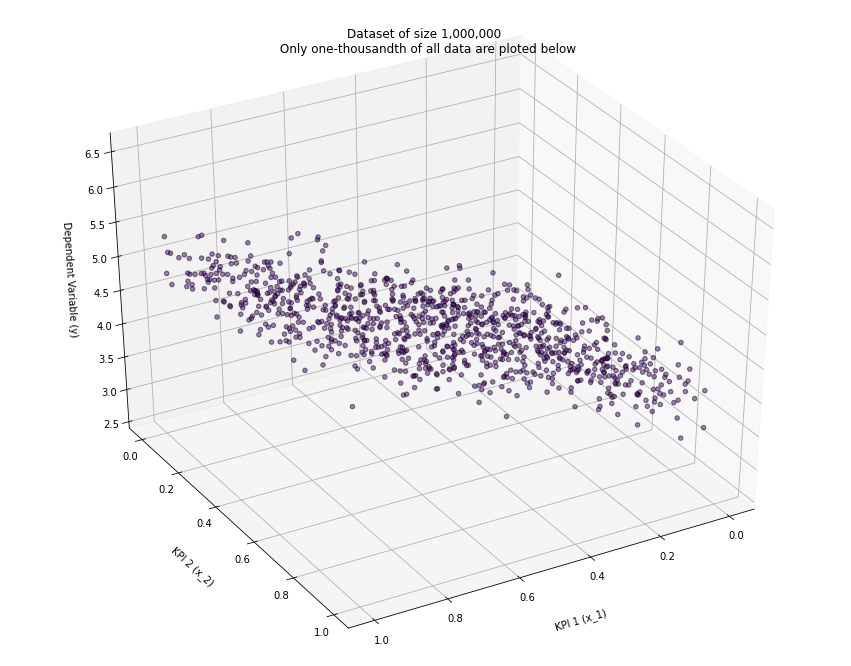

In [12]:
import numpy as np
import scipy.stats
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import display, Latex

#say one million households in our thought city
n = 1000000
a = np.array([[3, 2, 1]])
#may use np.random.RandomState(seed) instead of np.random to specify seed, such as 0, for precisely repeatable output
x = np.random.rand(n, 2)
#for homogeneity
xHomo = np.concatenate((np.ones_like(x[:,[0]]), x), axis = 1)
noiseLvl = 0.3
noise = np.random.normal(scale=noiseLvl,size=(n,1))
y = xHomo.dot(a.T) + noise

display(Latex(f"Model \ Ground \ Truth: y = {a[0,0]} + ({a[0,1]})x_1 + ({a[0,2]})x_2."))
fig1 = plt.figure(figsize = (15,12))
ax = fig1.gca(projection='3d')
#just plot out one-thousandth  of all data
ax.scatter(xHomo[::1000][:,1], xHomo[::1000][:,2], y[::1000], s = 20, marker = 'o', edgecolors= 'k', alpha = 0.5, c = "indigo")
ax.set_title('Dataset of size 1,000,000 \n Only one-thousandth of all data are ploted below')
ax.set_xlabel('KPI 1 (x_1)', labelpad = 20)
ax.set_ylabel('KPI 2 (x_2)',  labelpad = 20)
ax.set_zlabel('Dependent Variable (y)', labelpad = 10)
ax.view_init(36, 60)

### 1.3.2 Helper Functions
Note that some functions are logged and scaled for efficient computation

In [13]:
#Make sure to run helper functions
def log_prior(theta):
  #Assume Gaussian is often a good idea
  theta_prior = scipy.stats.norm(0.5, 0.5).pdf(theta)
  #log probability transforms multiplication to summation
  return np.log(theta_prior).sum()

def log_likelihood(theta, minibatch = 1000):
  sample = np.random.randint(n, size = minibatch)
  xHs = xHomo[sample]
  ys = y[sample]
  ysHat = xHs.dot(theta.T)
  individual_likelihood = scipy.stats.norm(ysHat, noiseLvl).pdf(ys.ravel())
  #usually noiseLvl is not in our prior knowledge, but still one could estimate from the sample variance
  #print("likelihood", np.log(individual_likelihood).shape)
  return np.sum(np.log(individual_likelihood))

def log_posterior(theta, minibatch = 1000):
  return log_prior(theta) + log_likelihood(theta, minibatch = 1000)

def proposal_function(theta):
  #print("proposal", np.random.normal(theta, 0.5).shape)
  return np.random.normal(theta, 0.5)

### 1.3.3 Markov Chain Monte Carlo (MCMC)
*Markov Chain Monte Carlo* (MCMC) comprised of a class of algorithms. MCMC involved transition of states like a (dynamically changing) Markov Chain; summarizing result from random process as in Monte Carlo Simulation; and updating values in the Bayesian manner. In the following, we will employ one type of MCMC known as *Metropolis Hastings* to finish the job~ 

Please make sure previous code cells in Section 1.3 are running properly before running the next one. Upon successful execution, you may try to identify where Markov Chain had been employed and how Monte Carlo appear. 

P.S. If one search for "np.random.normal" and "scipy.stats.norm" in codes, one would realize how often we resort to Gaussian distribution throughout the process!

In [14]:
#Make sure previous cells had been run before this one

# Markov Chain Monte Carlo
theta0 = [0.5, 0.5, 0.5]        # start value
thetaRecord = np.zeros([1001,3]) # prepare to record the results
thetaRecord[0] = theta0
minibatch = 1000
print('Taking 1000 sample in each step. Simulation in progress:')
for step in range(1, 1001):
  thetaOld = thetaRecord[step-1, :]
  thetaProposal = proposal_function(thetaOld)
  # restore from log numbers
  prob = np.exp(log_posterior(thetaProposal, minibatch) - log_posterior(thetaOld, minibatch))
  #### transition of states ###
  if np.random.uniform(0,1) < prob:
    thetaRecord[step, :] = thetaProposal    # jump
  else:
    thetaRecord[step, :] = thetaOld         # stay
  if step%100 == 0:
    print('Step {} out of 1000 steps, so far {} sample had been taken.'.format(step, step*1000))
print('\n Among these 1000000 data, some data might be sampled more than once and some might be missed. So far, the sampling result gives: \n')
burn_in = 500
thetaPosterior = thetaRecord[burn_in:, :]
theta = thetaPosterior.mean(axis=0)

toPrint = np.around(theta, decimals=4)
display(Latex(f"y ≈ {toPrint[0]} + ({toPrint[1]})x_1 + ({toPrint[2]})x_2."))
print("\n Could you recover at least approximately the model ground truth? \n Re-do for different output, or compare with your classmate ;) \n Do you now get the sense of employing random process to figure out some deterministic unknown?")


Taking 1000 sample in each step. Simulation in progress:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


Step 100 out of 1000 steps, so far 100000 sample had been taken.
Step 200 out of 1000 steps, so far 200000 sample had been taken.
Step 300 out of 1000 steps, so far 300000 sample had been taken.
Step 400 out of 1000 steps, so far 400000 sample had been taken.
Step 500 out of 1000 steps, so far 500000 sample had been taken.
Step 600 out of 1000 steps, so far 600000 sample had been taken.
Step 700 out of 1000 steps, so far 700000 sample had been taken.
Step 800 out of 1000 steps, so far 800000 sample had been taken.
Step 900 out of 1000 steps, so far 900000 sample had been taken.
Step 1000 out of 1000 steps, so far 1000000 sample had been taken.

 Among these 1000000 data, some data might be sampled more than once and some might be missed. So far, the sampling result gives: 



<IPython.core.display.Latex object>


 Could you recover at least approximately the model ground truth? 
 Re-do for different output, or compare with your classmate ;) 
 Do you now get the sense of employing random process to figure out some deterministic unknown?


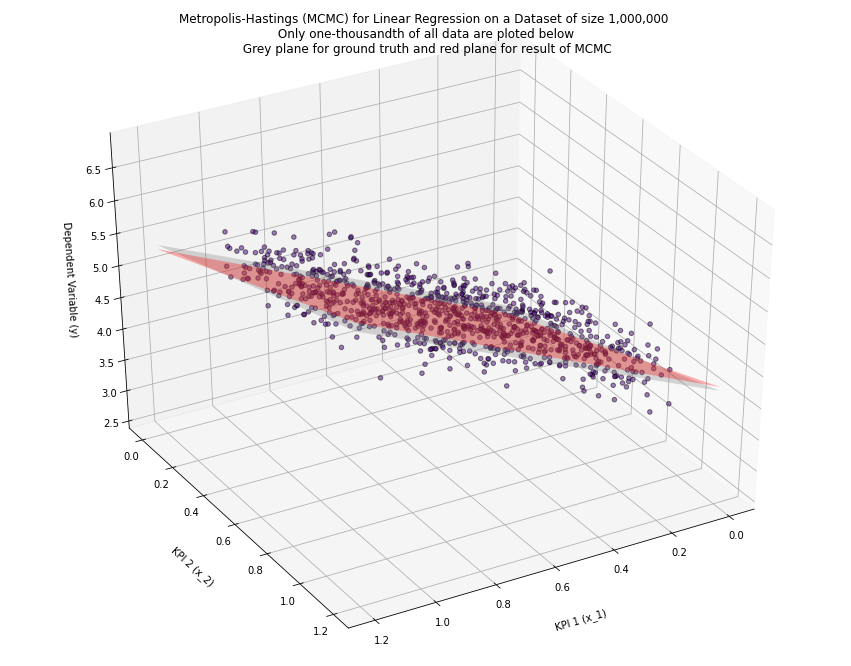

In [15]:
#Visualization
xx1, xx2 = np.meshgrid(np.array([[0,1]])*1.2, np.array([[0,1]])*1.2)
YY = a[0,0] + xx1* a[0,1] + xx2* a[0,2]
Yregression = theta[0] + xx1* theta[1] + xx2* theta[2]
potential = noise < 0
flat = potential.flatten()
fig1 = plt.figure(figsize = (15,12))
ax = fig1.gca(projection='3d')
ax.plot_surface(xx1, xx2, YY, color = 'grey', alpha = 0.3)
ax.plot_surface(xx1, xx2, Yregression, color = 'red', alpha = 0.3)
ax.scatter(xHomo[::1000][:,1], xHomo[::1000][:,2], y[::1000], s = 20, marker = 'o', edgecolors= 'k', alpha = 0.5, c = "indigo")
ax.set_title('Metropolis-Hastings (MCMC) for Linear Regression on a Dataset of size 1,000,000 \n Only one-thousandth of all data are ploted below \n Grey plane for ground truth and red plane for result of MCMC')
ax.set_xlabel('KPI 1 (x_1)', labelpad = 20)
ax.set_ylabel('KPI 2 (x_2)',  labelpad = 20)
ax.set_zlabel('Dependent Variable (y)', labelpad = 10)
ax.view_init(36, 60)

Visually, the two planes almost coincide! Yet, as an optimization problem, one would like to look into the loss function. This is easy in this case, We just need to consider difference of regression value and true value, and summarize these errors by root mean square (RMS). To speed up, we take sample for one-thousandth of all data.

In [16]:
error = 0
for i in range(len(x), 1000):
  error += (y[i]-(thetaPosterior.mean(axis=0)[1] * x[i] + thetaPosterior.mean(axis=0)[0]))**2
error = error**(1/2)
print('RMS error is:',error)

RMS error is: 0.0


### 1.4 How about classification? Logistic Regression!

**Just some thoughts here**

After one had some understanding on linear regression, classification problem would be very easy to comprehend.

Remember the logistic curve in [ST5-000-Basics](https://colab.research.google.com/github/HanlunAI/ATasteOfDeepLearning/blob/main/ST5_000_Basics.ipynb)? One could composite a linear relation with the logistic function to get a model for binary classification, sometimes refer to as the logistic regression.

For example, in our thought city with 1,000,000 household, some of them has their own minor problems (water leakage, exposure to noise and vibration, etc). For certain likelihood, these troublesome household would appear beneath the regression plane. Once their problems are handle, these household value may go up. And so these are the properties under the radar, and their identification is certain binary classification task.

For classification task consisting of many classes, one may decomposition it into many binary classification tasks. Ideas related to such include the [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding/notebook) and [softmax function](https://deepai.org/machine-learning-glossary-and-terms/softmax-layer). We will also demonstration a modern approach in the [next notebook](https://colab.research.google.com/github/HanlunAI/ATasteOfDeepLearning/blob/main/ST5_002_Modern.ipynb). Non-linearity would also be introduced there!

### 1.5 Who Else Care about Supervised Learning

Actually, a lot of people would care. Supervised learning has application across different domains. It is useful when we need to infer/retrieve information from high-dimensional input, possible use cases ranges from asset price evaluation to speech recognition; from handwriting recognition to motion capture; the list goes on...

**1.5.1 Our world is getting more interesting**

Let's look into one particular automation made by [DeepMotion](https://www.deepmotion.com/animate-3d?gclid=CjwKCAjwoMSWBhAdEiwAVJ2ndivZRz1ihTYFE0PWPCjMR87No2fymNUmVrAhwmIvCFtOVNA77Z4IZhoCRTAQAvD_BwE) available online:


In [17]:
from IPython.display import HTML
HTML('<iframe width="960" height="540" src="https://www.youtube.com/embed/97zGmkdhSNU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

**1.5.2 Tell us your Wishes**

To think about new applications, we may make reference to how an existing one work. 

An automatic video-to-animation pipeline may involve these components:
Body Key-points Detection, 3D Skeleton Modeling, Character Design and Graphics Generation. Supervised learning trained with massive data could be used to classify those pixels corresponding to body key-points in each frame. Though it is just a perception task in the pipeline; it had been the bottleneck and is *the last mile* of the way to this automation. Likewise, other perception tasks in supervised learning could be the last mile of some automatic system. 

Now, you may tell us your thoughts about the future world with this [Google Form](https://docs.google.com/forms/d/e/1FAIpQLSfwohGaqSMqmuhtymn08PLTdgQQTYYtCvoAlFt_O2x12sccaQ/viewform?usp=sf_link).

© Hanlun Artificial Intelligence Limited